In [ ]:
!unzip /content/MildDemented.zip
!unzip /content/ModerateDemented.zip
!unzip /content/NonDemented.zip
!unzip /content/VeryMildDemented.zip

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Concatenate, Input
from tensorflow.keras.applications import DenseNet201, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action="ignore")

# Check for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and enabled for TensorFlow")

# Define file directories and labels
MildDemented_dir = "content/AugmentedAlzheimerDataset/MildDemented"
ModerateDemented_dir = "content/AugmentedAlzheimerDataset/ModerateDemented"
NonDemented_dir = "content/AugmentedAlzheimerDataset/NonDemented"
VeryMildDemented_dir = "content/AugmentedAlzheimerDataset/VeryMildDemented"
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# DataFrame of image paths and labels
filepaths, labels = [], []
for i, path in enumerate(dict_list):
    flist = os.listdir(path)
    for f in flist:
        filepaths.append(os.path.join(path, f))
        labels.append(class_labels[i])

Alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

# Image Data Generator
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train = image_gen.flow_from_dataframe(train_set, x_col="filepaths", y_col="labels",
                                      target_size=(244, 244), class_mode="categorical", batch_size=128)
val = image_gen.flow_from_dataframe(val_set, x_col="filepaths", y_col="labels",
                                    target_size=(244, 244), class_mode="categorical", batch_size=128)
test = image_gen.flow_from_dataframe(test_images, x_col="filepaths", y_col="labels",
                                     target_size=(244, 244), class_mode="categorical", batch_size=128)

# Define the multi-branch model with DenseNet201 and VGG16 branches
input_shape = (244, 244, 3)
input_tensor = Input(shape=input_shape)

# DenseNet201 branch
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=input_tensor)
densenet_output = GlobalAveragePooling2D()(densenet_model.output)
densenet_output = BatchNormalization()(densenet_output)

# VGG16 branch
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
vgg_output = GlobalAveragePooling2D()(vgg_model.output)
vgg_output = BatchNormalization()(vgg_output)

# Combine branches
combined = Concatenate()([densenet_output, vgg_output])
combined = Dense(1024, activation='relu')(combined)
combined = Dropout(0.5)(combined)
final_output = Dense(4, activation='softmax')(combined)

# Define and compile the model
model = Model(inputs=input_tensor, outputs=final_output)

# Freeze initial layers
for layer in densenet_model.layers:
    layer.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# Learning rate decay schedule
initial_lr = 0.001
lr_schedule = ExponentialDecay(initial_lr, decay_steps=10000, decay_rate=0.96, staircase=True)
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

2024-11-29 19:06:47.942700: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 19:06:47.991725: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU is available and enabled for TensorFlow
Found 19030 validated image filenames belonging to 4 classes.
Found 4758 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.


2024-11-29 19:06:50.017379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78738 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:2a:00.0, compute capability: 9.0


In [3]:
#model.summary()

Epoch 1/25


2024-11-29 19:07:01.444099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-11-29 19:07:02.109763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-29 19:07:03.408333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f76849576f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-29 19:07:03.408375: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA H100 PCIe, Compute Capability 9.0
2024-11-29 19:07:03.415003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-29 19:07:03.603512: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

149/149 [==============================] - 200s 1s/step - loss: 0.9154 - accuracy: 0.6327 - val_loss: 0.9177 - val_accuracy: 0.6261 - lr: 0.0010
Epoch 2/25
149/149 [==============================] - 193s 1s/step - loss: 0.6301 - accuracy: 0.7236 - val_loss: 0.6599 - val_accuracy: 0.7228 - lr: 0.0010
Epoch 3/25
149/149 [==============================] - 187s 1s/step - loss: 0.5603 - accuracy: 0.7585 - val_loss: 0.5386 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 4/25
149/149 [==============================] - 173s 1s/step - loss: 0.5026 - accuracy: 0.7846 - val_loss: 0.4754 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 5/25
149/149 [==============================] - 200s 1s/step - loss: 0.4672 - accuracy: 0.8024 - val_loss: 0.4158 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 6/25
149/149 [==============================] - 183s 1s/step - loss: 0.4399 - accuracy: 0.8154 - val_loss: 0.3763 - val_accuracy: 0.8441 - lr: 0.0010
Epoch 7/25
149/149 [==============================] - 185s 1s/step - loss: 

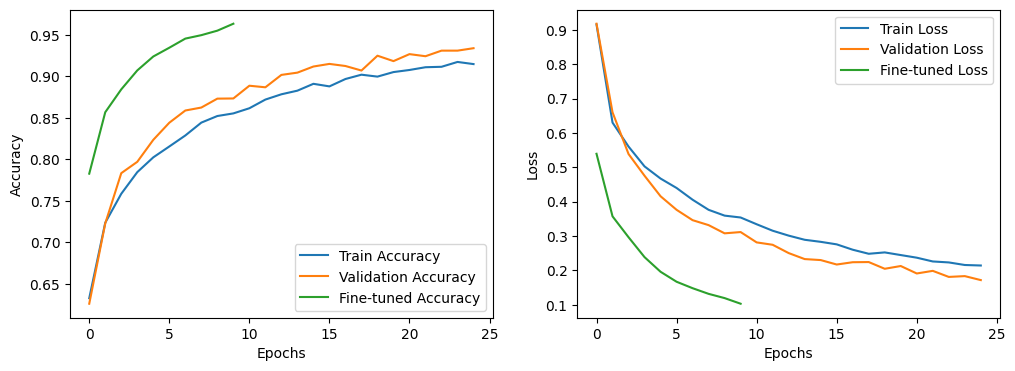

In [4]:


# Train the model
history = model.fit(train, epochs=25, validation_data=val, callbacks=[early_stopping, reduce_lr])

# Unfreeze all layers for fine-tuning
for layer in densenet_model.layers:
    layer.trainable = True
for layer in vgg_model.layers:
    layer.trainable = True

# Compile again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping])

# Evaluation
test_loss, test_acc = model.evaluate(test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save the model
model.save("hybrid_alzheimer_model2.h5")

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

# Step 1: Get Predictions
y_pred = model.predict(test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Extract True Labels
# Since `test` is a generator, we need to access the labels through `classes` attribute
y_true_labels = test.classes

# Get class names in the order they are indexed
class_indices = test.class_indices
class_labels = list(class_indices.keys())

# Step 3: Generate Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get Predictions
y_pred = model.predict(test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Step 2: Extract True Labels
y_true_labels = test.classes

# Get class names in the order they are indexed
class_indices = test.class_indices
class_labels = list(class_indices.keys())

# Step 3: Generate Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Step 4: Calculate Precision, Recall, F1-score
report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print("Classification Report:")
print(report)

# Step 5: Plot Enhanced Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar=True, linewidths=0.5, linecolor='black', square=True)

# Customization to match your provided format
plt.title("Alzheimer's Disease Diagnosis", fontsize=16)
plt.xlabel("Prediction", fontsize=14)
plt.ylabel("Truth", fontsize=14)

# Display the plot
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the model
model = load_model("hybrid_alzheimer_model.h5")

# Step 2: Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Step 3: Make Predictions
y_pred = model.predict(test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test.classes

# Get class names in the order they are indexed
class_indices = test.class_indices
class_labels = list(class_indices.keys())

# Step 4: Calculate Accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Calculated Test Accuracy: {accuracy * 100:.2f}%")

# Step 5: Generate Confusion Matrix and Classification Report
cm = confusion_matrix(y_true_labels, y_pred_labels)
report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print("\nClassification Report:\n", report)

# Step 6: Plot Enhanced Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar=True, linewidths=0.5, linecolor='black', square=True)

plt.title("Alzheimer's Disease Diagnosis", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()


GPU is available and enabled for TensorFlow
Found 10196 validated image filenames belonging to 4 classes.
80/80 [==============================] - 20s 224ms/step - loss: 0.0680 - accuracy: 0.9755
Test Accuracy (Direct Evaluation): 97.55%
80/80 [==============================] - 19s 199ms/step
Calculated Test Accuracy (Predictions): 97.55%

Classification Report:
                     precision    recall  f1-score   support

     Mild Demented       0.99      0.98      0.99      2693
 Moderate Demented       1.00      1.00      1.00      1977
      Non Demented       0.95      0.98      0.96      2811
Very Mild Demented       0.97      0.95      0.96      2715

          accuracy                           0.98     10196
         macro avg       0.98      0.98      0.98     10196
      weighted avg       0.98      0.98      0.98     10196



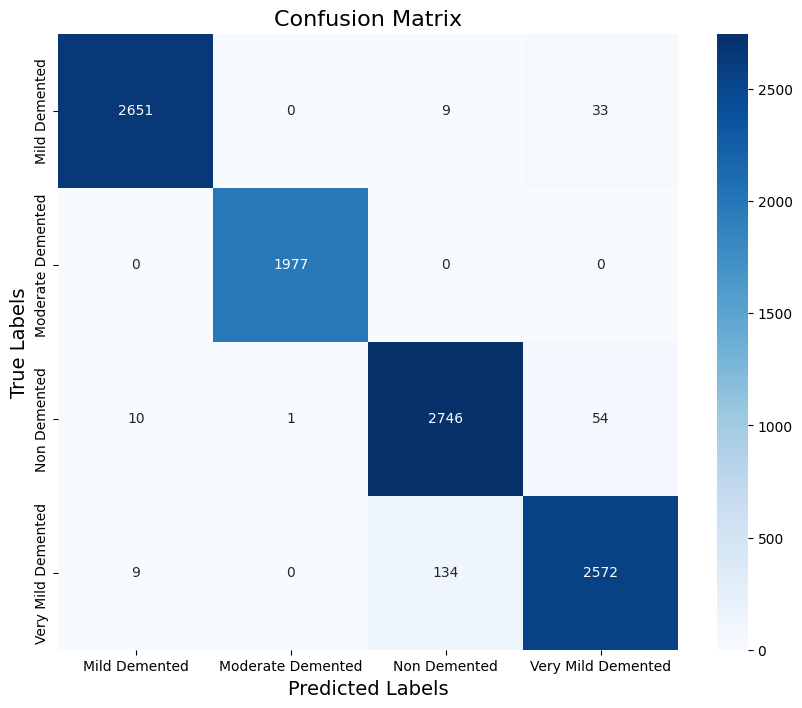

In [5]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and enabled for TensorFlow")

# Step 1: Recreate the test dataset DataFrame

# Define directories for each class (Adjust paths if needed)
MildDemented_dir = "content/AugmentedAlzheimerDataset/MildDemented"
ModerateDemented_dir = "content/AugmentedAlzheimerDataset/ModerateDemented"
NonDemented_dir = "content/AugmentedAlzheimerDataset/NonDemented"
VeryMildDemented_dir = "content/AugmentedAlzheimerDataset/VeryMildDemented"

# List of class directories and labels
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# Collect file paths and labels
filepaths, labels = [], []
for i, path in enumerate(dict_list):
    for f in os.listdir(path):
        filepaths.append(os.path.join(path, f))
        labels.append(class_labels[i])

# Create DataFrame
Alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Split dataset into test set (30% as before)
from sklearn.model_selection import train_test_split
_, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)

# Step 2: Set up ImageDataGenerator for test set
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Create the test data generator
test = image_gen.flow_from_dataframe(
    test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    class_mode="categorical",
    batch_size=128,
    shuffle=False  # Disable shuffle for correct evaluation
)

# Step 3: Load the pre-trained model
model = load_model("hybrid_alzheimer_model2.h5")

# Step 4: Evaluate the model using the test set
test_loss, test_acc = model.evaluate(test)
print(f"Test Accuracy (Direct Evaluation): {test_acc * 100:.2f}%")

# Step 5: Predict on the test data
test.reset()  # Reset the generator to start from the first image
y_pred = model.predict(test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test.classes

# Step 6: Calculate manual accuracy
calculated_accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Calculated Test Accuracy (Predictions): {calculated_accuracy * 100:.2f}%")

# Step 7: Display classification report
class_labels = list(test.class_indices.keys())
print("\nClassification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

# Step 8: Plot confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()


In [ ]:
# import shap
# import cv2
# from tensorflow.keras.models import Model
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# # SHAP Integration
# # Select a subset of test images for SHAP analysis
# explainer = shap.GradientExplainer(model, train)
# shap_values = explainer.shap_values(test)

# # Plot SHAP values for a specific prediction
# shap.image_plot(shap_values, test_images[0:10])

# # Grad-CAM Integration
# def get_gradcam_heatmap(model, image, last_conv_layer_name):
#     grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(image)
#         loss = predictions[:, np.argmax(predictions[0])]

#     # Get gradients of the target class with respect to the last conv layer output
#     grads = tape.gradient(loss, conv_outputs)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # Multiply pooled grads with conv layer output
#     conv_outputs = conv_outputs[0]
#     heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

#     # Normalize heatmap between 0 & 1 for visualization
#     heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
#     return heatmap.numpy()

# # Load a sample image and preprocess it
# sample_image_path = test_images.iloc[0]['filepaths']
# img = load_img(sample_image_path, target_size=(244, 244))
# img_array = img_to_array(img) / 255.0
# img_array = np.expand_dims(img_array, axis=0)

# # Apply Grad-CAM to the sample image
# heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name="conv5_block32_concat")  # Last conv layer in DenseNet201

# # Display heatmap
# plt.matshow(heatmap)
# plt.show()

# # Superimpose heatmap on the original image
# def overlay_heatmap(heatmap, image_path, alpha=0.4):
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (244, 244))
#     heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#     superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
#     return superimposed_img

# # Display the overlayed image
# overlayed_img = overlay_heatmap(heatmap, sample_image_path)
# plt.imshow(overlayed_img)
# plt.axis('off')
# plt.show()
import shap
import cv2
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# SHAP Integration
# Select a subset of test images for SHAP analysis
explainer = shap.GradientExplainer(model, train)
shap_values = explainer.shap_values(test, nsamples=200)

# Plot SHAP values for a specific prediction
shap.image_plot(shap_values, test_images.iloc[:10]['filepaths'])

# Grad-CAM Integration
def get_gradcam_heatmap(model, image, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, np.argmax(predictions[0])]
    # Get gradients of the target class with respect to the last conv layer output
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Multiply pooled grads with conv layer output
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # Normalize heatmap between 0 & 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Load a sample image and preprocess it
sample_image_path = test_images.iloc[0]['filepaths']
img = load_img(sample_image_path, target_size=(244, 244))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Apply Grad-CAM to the sample image
heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name="conv5_block32_concat")  # Last conv layer in DenseNet201

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose heatmap on the original image
def overlay_heatmap(heatmap, image_path, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (244, 244))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

# Display the overlayed image
overlayed_img = overlay_heatmap(heatmap, sample_image_path)
plt.imshow(overlayed_img)
plt.axis('off')
plt.show()